In [ ]:
# --- AffinityNet Full Stage 1 + Stage 2 Implementation (with Random Walk) ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torchvision.models import resnet50
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
import gc

def download_data(pth=None, split="trainval"):
    image_transform = transforms.Compose([
        transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor()
    ])
    mask_transform = transforms.Compose([
        transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.PILToTensor()
    ])
    dataset = OxfordIIITPet(
        root=pth,
        split=split,
        target_types=("binary-category", "segmentation"),
        download=True,
        transform=image_transform,
        target_transform=lambda t: (t[0], mask_transform(t[1]))
    )
    return dataset

# --- Classification Model ---
class FrozenResNetCAM(nn.Module):
    def __init__(self, num_classes=37):
        super().__init__()
        resnet = resnet50(pretrained=True, replace_stride_with_dilation=[False, False, True])
        for param in resnet.parameters():
            param.requires_grad = False

        # Split layers for easier access

        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        # self.layer5 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(resnet.fc.in_features, num_classes)

    def forward(self, x):
        x = self.layer0(x)
        f1 = self.layer1(x)
        f2 = self.layer2(f1)
        f3 = self.layer3(f2)
        f4 = self.layer4(f3)
        # f5 = self.layer5(f4)

        pooled = self.avgpool(f4)
        flat = pooled.view(pooled.size(0), -1)
        logits = self.fc(flat)

        # Return all feature maps for LayerCAM
        return logits, [f2, f3, f4]

class LayerCAMGenerator:
    def __init__(self, model, target_layer_names=["layer2", "layer3", "layer4"]):
        self.model = model.eval()
        self.target_layer_names = target_layer_names

        self.activations = {}
        self.gradients = {}

        self._register_hooks()

    def _register_hooks(self):
        for name in self.target_layer_names:
            layer = getattr(self.model, name)
            layer.register_forward_hook(self._make_forward_hook(name))
            layer.register_full_backward_hook(self._make_backward_hook(name))

    def _make_forward_hook(self, name):
        def hook(module, input, output):
            self.activations[name] = output
        return hook

    def _make_backward_hook(self, name):
        def hook(module, grad_input, grad_output):
            self.gradients[name] = grad_output[0]
        return hook


    def generate(self, images, class_idx=None):
        self.activations.clear()
        self.gradients.clear()

        images = images.unsqueeze(0)
        images = images.requires_grad_()

        with torch.enable_grad():
            logits, _ = self.model(images)

            if class_idx is None:
                class_idx = torch.argmax(logits, dim=1)

            class_scores = logits.gather(1, class_idx.view(-1, 1)).squeeze()
            class_scores.backward(torch.ones_like(class_scores), retain_graph=True)

        layer_cams = []

        for name in self.target_layer_names:
            act = self.activations[name]     # (B, C, H, W)
            grad = self.gradients[name]      # (B, C, H, W)

            with torch.no_grad():
                weights = F.relu(grad * act)
                cam = weights.sum(dim=1)         # (B, H, W)
                cam = F.relu(cam)

                # Normalize per image (detach and operate on a copy)
                for i in range(cam.shape[0]):
                    c = cam[i]
                    c = c.detach()
                    c -= c.min()
                    c /= (c.max() + 1e-8)
                    cam[i] = c

                cam = F.interpolate(cam.unsqueeze(1), size=(224, 224), mode="bilinear", align_corners=False)
                layer_cams.append(cam.squeeze(1).detach())  # detach CAM from graph

            del act, grad, weights, cam  # free up memory

        final_cam = sum(layer_cams) / len(layer_cams)
        final_cam = final_cam.detach()

        del logits, class_scores, images, layer_cams
        torch.cuda.empty_cache()
        gc.collect()

        return final_cam  # (B, H, W)


    def generate_bg_cam(self, image_tensor, valid_class_indices, alpha=1.0):
        """
        Mimics CAMGenerator's bg+fg map output for integration with AffinityNet.
        """
        #all_cams = self.generate_all_cams(image_tensor)
        all_cams = self.generate(image_tensor, valid_class_indices)

        mask = torch.zeros_like(all_cams)
        valid_cams = all_cams

        max_obj_cam, _ = valid_cams.max(dim=0)  # (H, W)
        m_bg = 1.0 - ((1.0 - max_obj_cam).clamp(min=0.0) ** alpha)

        # Resize for consistency
        m_bg_resized = F.interpolate(
            m_bg.unsqueeze(0).unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False
        ).squeeze()

        max_obj_cam_resized = F.interpolate(
            max_obj_cam.unsqueeze(0).unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False
        ).squeeze()

        return m_bg_resized, max_obj_cam_resized


# --- Updated CAM Generator ---
class CAMGenerator:
    def __init__(self, model):
        self.model = model.eval()

    def generate_all_cams(self, image_tensor):
        with torch.no_grad():
            logits, features = self.model(image_tensor.unsqueeze(0))  # shape: (1, C, H, W)
            features = features[-1]  # shape: (C_feat, H, W)
            features = features.squeeze(0)  # (C_feat, H, W)

            all_cams = []
            for class_idx in range(logits.shape[1]):
                weights = self.model.fc.weight[class_idx]  # (C_feat,)
                cam = torch.einsum("c,chw->hw", weights, features)  # (H, W)
                cam = F.relu(cam)

                cam -= cam.min()
                cam /= cam.max() + 1e-8  # Normalize to [0,1]
                all_cams.append(cam)

            all_cams = torch.stack(all_cams, dim=0)  # Shape: (num_classes, H, W)
            return all_cams  # Return CAMs for all classes

    def generate_bg_cam(self, image_tensor, valid_class_indices, alpha=1.0):
        """
        image_tensor: (C, H, W)
        valid_class_indices: list of class indices (e.g., ground truth labels for this image)
        alpha: exponent for shaping M_bg
        """
        all_cams = self.generate_all_cams(image_tensor)

        # Zero out CAMs for irrelevant classes
        mask = torch.zeros_like(all_cams)
        for idx in valid_class_indices:
            mask[idx] = 1.0
        valid_cams = all_cams * mask

        # Max activation across valid classes at each (x, y)
        max_obj_cam, _ = valid_cams.max(dim=0)  # Shape: (H, W)

        # M_bg = (1 - max_c CAM_c)^alpha
        m_bg = 1.0 - ((1.0 - max_obj_cam).clamp(min=0.0) ** alpha)

        # Resize to 224x224 for visualization or consistency
        m_bg_resized = F.interpolate(
            m_bg.unsqueeze(0).unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False
        ).squeeze()

        max_obj_cam_resized = F.interpolate(
            max_obj_cam.unsqueeze(0).unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False
        ).squeeze()

        return m_bg_resized, max_obj_cam_resized


def train_fc_only(model, dataloader, device, epochs=10):
    model.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)  # Only train FC layer
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        total_loss, correct, total = 0.0, 0, 0
        for imgs, (labels, _) in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits, _ = model(imgs)
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += imgs.size(0)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / total:.4f} - Acc: {100 * correct / total:.2f}%")

    model.eval()

In [ ]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset = download_data("/content/OxfordIIITPetDataset", split="trainval")
loader = DataLoader(dataset, batch_size=16, shuffle=True)

100%|██████████| 792M/792M [00:06<00:00, 113MB/s] 
100%|██████████| 19.2M/19.2M [00:00<00:00, 77.4MB/s]


In [ ]:
classifier = FrozenResNetCAM().to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 139MB/s]


In [ ]:
train_fc_only(classifier, loader, device, epochs=5)
print("✅ Classifier trained.")

Epoch 1/5 - Loss: 0.1942 - Acc: 93.18%
Epoch 2/5 - Loss: 0.0674 - Acc: 97.80%
Epoch 3/5 - Loss: 0.0762 - Acc: 97.09%
Epoch 4/5 - Loss: 0.0665 - Acc: 97.69%
Epoch 5/5 - Loss: 0.0527 - Acc: 97.96%
✅ Classifier trained.


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
save_path = '/content/drive/MyDrive/Applied_Deep_Learning/classifier_weights_without_affinity.pth'
torch.save(classifier.state_dict(), save_path)

In [ ]:
save_path = '/content/drive/MyDrive/Applied_Deep_Learning/classifier_weights_without_affinity.pth'
classifier.load_state_dict(torch.load(save_path, map_location=torch.device('cuda')))
classifier.eval()

FrozenResNetCAM(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, k

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def overlay_cam_on_image(image_tensor, cam_tensor, alpha=0.5, colormap='gray'):
    """
    Overlays a CAM heatmap on an input image.

    Args:
        image_tensor (Tensor): Tensor of shape (3, H, W)
        cam_tensor (Tensor): Tensor of shape (H, W) with values in [0, 1]
        alpha (float): Opacity of the heatmap
        colormap (str): Matplotlib colormap to use

    Returns:
        np.ndarray: Overlay image as (H, W, 3) numpy array
    """
    # Convert image to numpy (H, W, 3)
    image = TF.to_pil_image(image_tensor.cpu())
    image_np = np.array(image).astype(np.float32) / 255.0

    # Normalize cam and convert to heatmap
    try:
        cam = cam_tensor.cpu().numpy()
    except:
        cam = cam_tensor.cpu().detach().numpy()
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    heatmap = plt.get_cmap(colormap)(cam)[:, :, :3]  # Drop alpha channel

    # Blend heatmap and image
    overlay = (1 - alpha) * image_np + alpha * heatmap
    overlay = np.clip(overlay, 0, 1)

    return overlay

In [ ]:
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
test_dataset = download_data("/content/OxfordIIITPetDataset", split="test")
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
pip install git+https://github.com/lucasb-eyer/pydensecrf.git

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-yrby1xcw
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-yrby1xcw
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0-cp311-cp311-linux_x86_64.whl size=3440329 sha256=432b9ce45380508f0c1be17fc403fff94b7de0c8f59f70d888597db751ecfb8c
  Stored in directory: /tmp/pip-ephem-wheel-cache-g3sq7__l/wheels/ce/8e/34/6dcfa200a9e2ae3627d8009b8bd1ca9b24512bec50a93304de
Successfully built pydensecrf


In [ ]:
from pydensecrf.utils import unary_from_softmax
import pydensecrf.densecrf as dcrf

def apply_dense_crf(img_np, cam_np):
    """
    Refines a CAM heatmap using DenseCRF
    """
    img_np = np.ascontiguousarray(img_np)  # ✅ Fix non-contiguous array

    h, w = cam_np.shape
    d = dcrf.DenseCRF2D(w, h, 2)

    probs = np.stack([1 - cam_np, cam_np], axis=0)  # Background, foreground
    probs = np.clip(probs, 1e-8, 1.0)

    unary = unary_from_softmax(probs)
    d.setUnaryEnergy(unary)

    d.addPairwiseGaussian(sxy=1, compat=2)
    d.addPairwiseBilateral(sxy=50, srgb=5, rgbim=img_np, compat=10)

    Q = d.inference(5)
    refined = np.argmax(Q, axis=0).reshape(h, w)

    return refined.astype(np.uint8)



In [ ]:
from skimage.measure import label as lb, regionprops
def keep_largest(mask):
    labeled = lb(mask)
    regions = regionprops(labeled)
    if not regions:
        return mask
    largest = max(regions, key=lambda r: r.area)
    return (labeled == largest.label).astype(np.uint8)


Regular CAM BG: IoU: 0.458 | Acc: 0.824
LayerCAM BG: IoU: 0.529 | Acc: 0.825


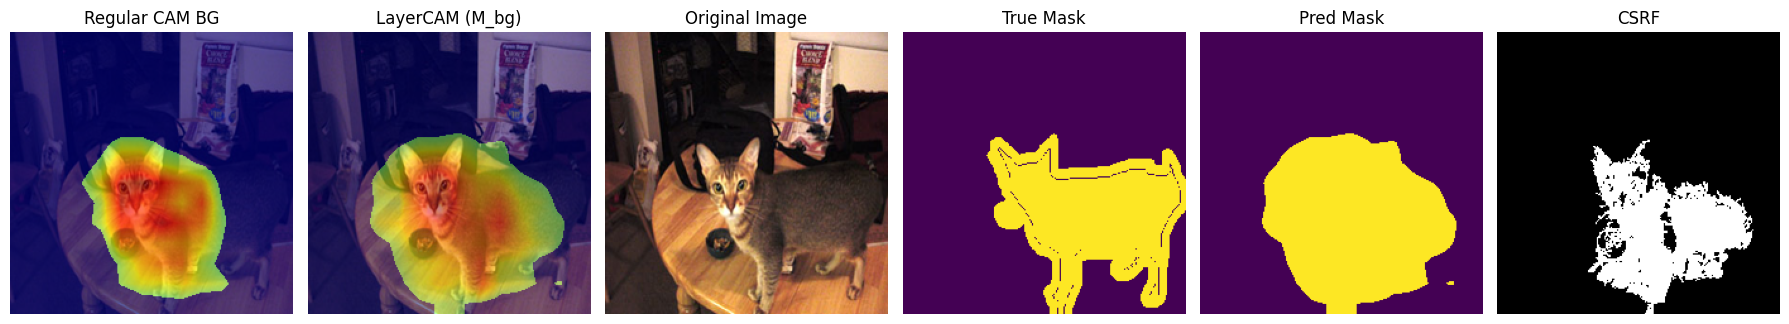

Regular CAM BG: IoU: 0.372 | Acc: 0.820
LayerCAM BG: IoU: 0.573 | Acc: 0.856


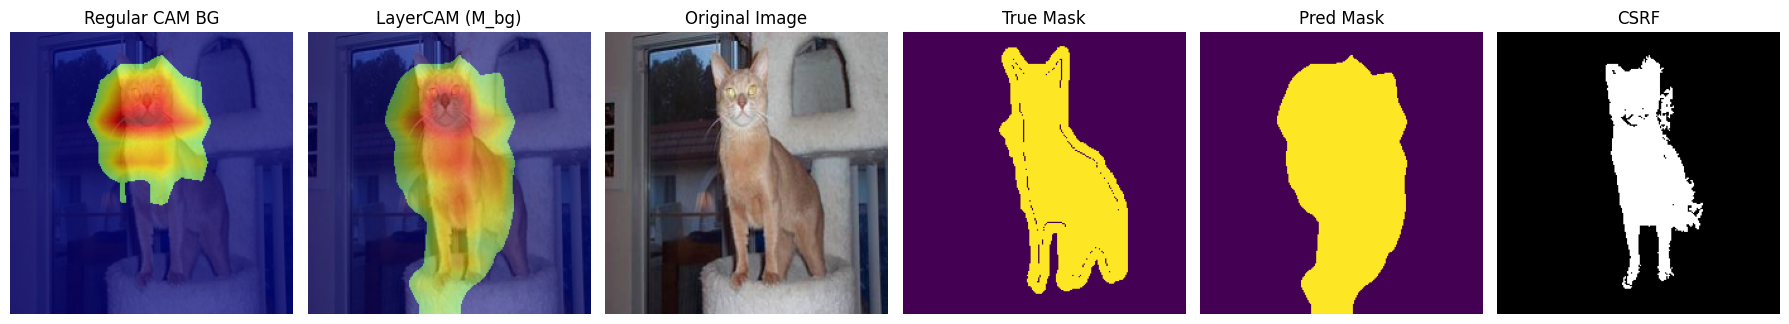

Regular CAM BG: IoU: 0.438 | Acc: 0.778
LayerCAM BG: IoU: 0.572 | Acc: 0.826


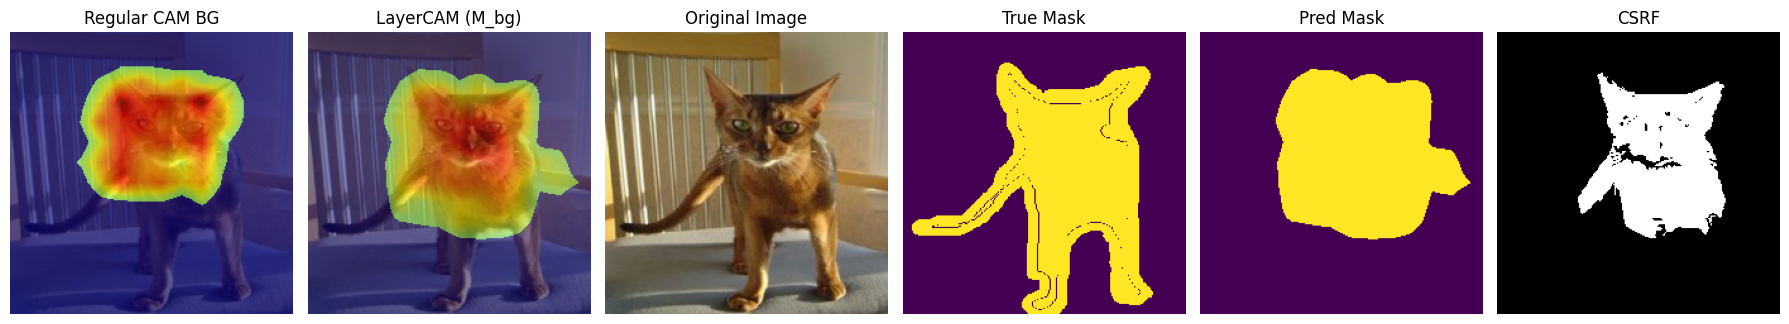

Regular CAM BG: IoU: 0.415 | Acc: 0.746
LayerCAM BG: IoU: 0.550 | Acc: 0.783


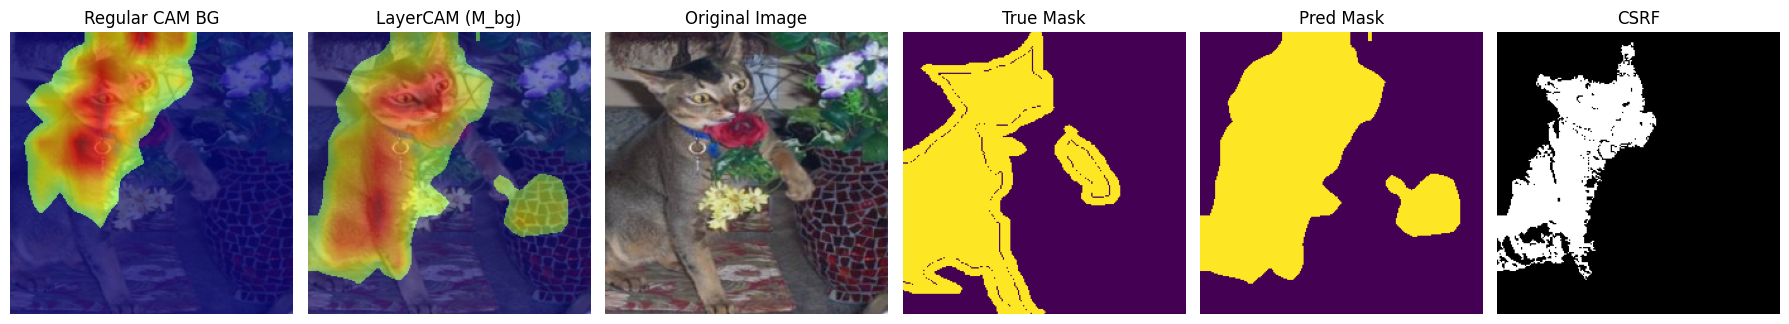

Regular CAM BG: IoU: 0.621 | Acc: 0.752
LayerCAM BG: IoU: 0.771 | Acc: 0.838


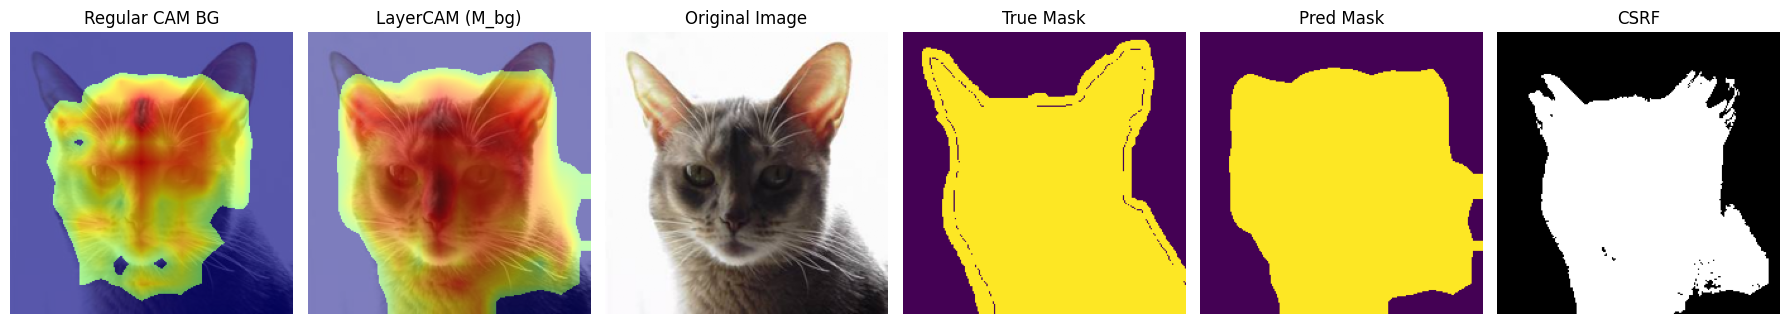

Regular CAM BG: IoU: 0.339 | Acc: 0.724
LayerCAM BG: IoU: 0.468 | Acc: 0.767


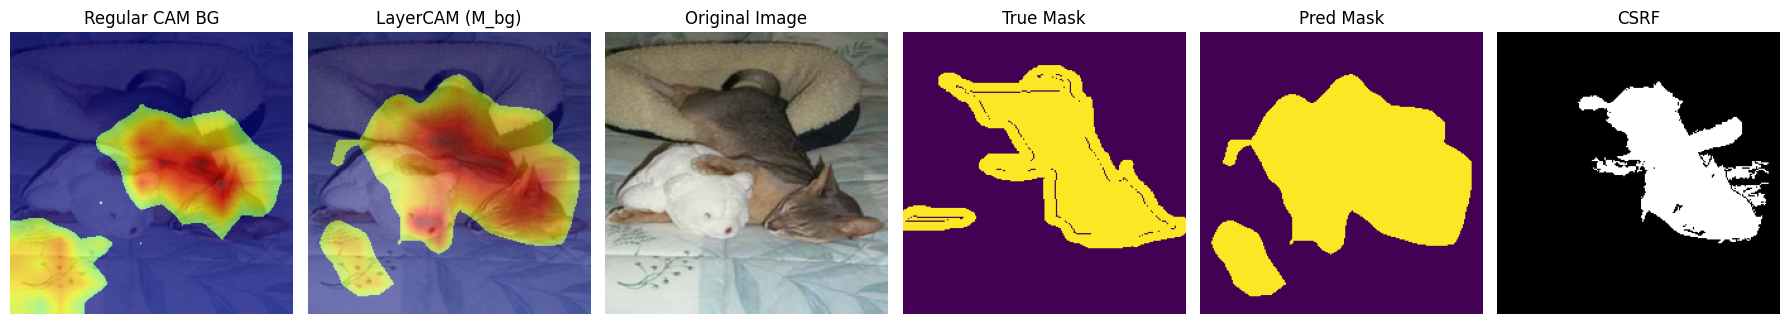

In [ ]:
from os import PRIO_PROCESS
p = 0
cam_gen = CAMGenerator(classifier)
layercam_gen = LayerCAMGenerator(classifier, target_layer_names=["layer3", "layer4"])  # f2, f3, f4
device = "cuda"
import cv2

def compute_iou_and_acc(pred_mask, true_mask):
    """
    Computes binary IoU and pixel accuracy.
    Args:
        pred_mask: Tensor of shape (H, W), foreground = >0
        true_mask: Tensor of shape (H, W), foreground = >0
    """
    pred_fg = (pred_mask > 0)
    true_fg = (true_mask > 0)

    intersection = (pred_fg & true_fg).sum().item()
    union = (pred_fg | true_fg).sum().item()
    correct = (pred_mask == true_mask).sum().item()
    total = true_mask.numel()

    iou = intersection / (union + 1e-8)
    acc = correct / total
    return iou, acc

for img, (label, true_mask) in test_loader:
    img = img[0].to(device)  # (3, H, W)
    true_mask = true_mask[0].to(device)
    for i in range(len(true_mask)):
        for j in range(len(true_mask[i])):
          for k in range(len(true_mask[i][j])):
            if true_mask[i][j][k] == 2 or true_mask[i][j][k] == 0:
              true_mask[i][j][k] = 0
            else:
              true_mask[i][j][k] = 1

    label = label[0].item() if isinstance(label[0], torch.Tensor) else label[0]

    valid_class_indices = [label]

    ### --- LAYERCAM GENERATOR ---
    class_tensor = torch.tensor(valid_class_indices).to(device)
    layercam_output = layercam_gen.generate(img, class_idx=class_tensor)  # (1, H, W)
    cam_bg, regular_cam = cam_gen.generate_bg_cam(img, class_tensor)  # (1, H, W)
    layercam_bg, _ = layercam_gen.generate_bg_cam(img, class_tensor, alpha=1.9)

    layercam = layercam_output.squeeze(0)  # (H, W)
    layercam[layercam < 0.5] = 0.0

    layercam_bg[layercam_bg < 0.5] = 0.0

    cam_bg[cam_bg <0.5] = 0.0

    # Build prediction masks
    pred_fg_mask = torch.zeros_like(cam_bg).long()
    pred_fg_mask[cam_bg > 0.0] = 1

    pred_bg_mask = torch.zeros_like(layercam_bg).long()
    pred_bg_mask[layercam_bg > 0.0] = 1

    # # Resize if needed
    if pred_fg_mask.shape != true_mask.shape:
        pred_fg_mask = F.interpolate(pred_fg_mask.unsqueeze(0).unsqueeze(0).float(), size=true_mask.shape[-2:], mode='nearest').squeeze().long()
        pred_bg_mask = F.interpolate(pred_bg_mask.unsqueeze(0).unsqueeze(0).float(), size=true_mask.shape[-2:], mode='nearest').squeeze().long()

    iou_fg, acc_fg = compute_iou_and_acc(pred_fg_mask, true_mask)
    iou_bg, acc_bg = compute_iou_and_acc(pred_bg_mask, true_mask)

    # Visualize overlays
    cam_overlay = overlay_cam_on_image(img, cam_bg, alpha=0.65, colormap='jet')
    layercam_bg_overlay = overlay_cam_on_image(img, layercam_bg, alpha=0.5, colormap='jet')

    # Convert image to uint8 for OpenCV (if not normalized)
    image_np = img.detach().cpu().permute(1, 2, 0).numpy()
    image_np = (image_np * 255).astype(np.uint8).clip(0, 255)

    image_np = img.detach().cpu().permute(1, 2, 0).numpy()
    image_np = (image_np * 255).astype(np.uint8).clip(0, 255)
    image_np = np.ascontiguousarray(image_np)

    refined_mask = apply_dense_crf(image_np, layercam_bg.squeeze().cpu().numpy())
    refined_mask = keep_largest(refined_mask)

    # Plots
    fig, ax = plt.subplots(1, 6, figsize=(18, 6))

    ax[0].imshow(cam_overlay)
    ax[0].set_title("Regular CAM BG")
    print(f"Regular CAM BG: IoU: {iou_fg:.3f} | Acc: {acc_fg:.3f}")
    ax[0].axis('off')

    ax[1].imshow(layercam_bg_overlay)
    ax[1].set_title("LayerCAM (M_bg)")
    #ax[1].set_xlabel(f"IoU: {iou_bg:.3f} | Acc: {acc_bg:.3f}")
    print(f"LayerCAM BG: IoU: {iou_bg:.3f} | Acc: {acc_bg:.3f}")
    ax[1].axis('off')

    ax[2].imshow(img.cpu().permute(1, 2, 0).numpy())
    ax[2].set_title("Original Image")
    ax[2].axis('off')

    ax[3].imshow(true_mask.cpu().permute(1, 2, 0).numpy())
    ax[3].set_title("True Mask")
    ax[3].axis('off')
    ax[4].imshow(pred_bg_mask.cpu().numpy())
    ax[4].set_title("Pred Mask")
    ax[4].axis('off')

    ax[5].imshow(refined_mask, cmap='gray')
    ax[5].set_title("CSRF")
    ax[5].axis('off')


    plt.tight_layout()
    plt.show()

    if p == 5:
        break
    p += 1

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
import numpy as np

class PseudoSegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.image_list = sorted(os.listdir(img_dir))
        self.mask_list = sorted(os.listdir(mask_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_list[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_list[idx])

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask

def joint_transform(image, mask):
    image = TF.resize(image, (256, 256))
    mask = TF.resize(mask, (256, 256), interpolation=Image.NEAREST)

    image = TF.to_tensor(image)
    image = TF.normalize(image, mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
    mask = torch.as_tensor(np.array(mask), dtype=torch.long)

    return image, mask


In [ ]:
import shutil
from torchvision.utils import save_image

def generate_pseudo_masks(
    loader,
    layercam_gen,
    cam_thresh=0.4,
    alpha=1.9,
    crf_compat=10,
    keep_largest_masks=True,
    apply_crf=True,
    run_id="default"):
    """
    Generate pseudo masks using LayerCAM + DenseCRF and save them to disk.
    """
    save_dir = f"/content/pseudo_masks"
    image_save_dir = f"/content/images"
    for d in [save_dir, image_save_dir]:
        if os.path.exists(d):
            shutil.rmtree(d)
        os.makedirs(d)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img_id = 0

    for imgs, (labels, _) in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        batch_size = imgs.size(0)
        for i in range(batch_size):
            if img_id >= 1000:
                break

            img = imgs[i]
            label = labels[i].item()
            class_tensor = torch.tensor([label]).to(device)

            cam_bg, _ = layercam_gen.generate(img, class_tensor, alpha=alpha)
            cam_bg = cam_bg.squeeze(0)
            cam_bg[cam_bg < cam_thresh] = 0.0

            # Convert image for CRF
            image_np = img.detach().cpu().permute(1, 2, 0).numpy()
            image_np = (image_np * 255).astype(np.uint8).clip(0, 255)
            image_np = np.ascontiguousarray(image_np)

            if apply_crf:
                refined_mask = apply_dense_crf(image_np, cam_bg.cpu().numpy(), compat=crf_compat)
            else:
                refined_mask = (cam_bg.cpu().numpy() > 0).astype(np.uint8)

            if keep_largest_masks:
                refined_mask = keep_largest(refined_mask)

            # Save pseudo mask
            mask_path = os.path.join(save_dir, f"{img_id}.png")
            save_image(torch.from_numpy(refined_mask).float().unsqueeze(0), mask_path)

            # Save image
            img_orig = img.cpu().clone()
            img_orig = (img_orig - img_orig.min()) / (img_orig.max() - img_orig.min())
            save_image(img_orig, os.path.join(image_save_dir, f"{img_id}.png"))

            img_id += 1

        if img_id >= 200:
            break

    print(f"Pseudo masks saved to: {save_dir}")
    print(f"Images saved to: {image_save_dir}")
    return image_save_dir, save_dir


In [ ]:
generate_pseudo_masks(loader, layercam_gen, cam_thresh=0.5, alpha=2.0, crf_compat = 10, keep_largest_masks = True, apply_crf = False)

Pseudo masks saved to: /content/pseudo_masks
Images saved to: /content/images


('/content/images', '/content/pseudo_masks')

### Regularisation Loss: Boundaries

Combine segmentation loss with boundary loss to encourage segmentation to be performed around edge of object in image

In [ ]:
def compute_affinities(image, sigma_color=0.1, sigma_space=5, window_size=5):
    """
    Compute affinity weights for a local window around each pixel.
    image: (B, 3, H, W) tensor
    returns: (B, K, H, W) affinity weights (K = window_size*window_size)
    """
    B, C, H, W = image.size()
    pad = window_size // 2
    image_padded = F.pad(image, (pad, pad, pad, pad), mode='reflect')

    neighbors = []
    affinities = []

    for dy in range(-pad, pad+1):
        for dx in range(-pad, pad+1):
            if dx == 0 and dy == 0:
                continue

            shifted = image_padded[:, :, pad+dy:pad+dy+H, pad+dx:pad+dx+W]
            diff = (image - shifted).pow(2).sum(dim=1, keepdim=True)  # color distance
            spatial_dist = dx**2 + dy**2

            weight = torch.exp(-diff / (2 * sigma_color**2) - spatial_dist / (2 * sigma_space**2))
            affinities.append(weight)

    return affinities  # list of (B, 1, H, W)


class ConstrainToBoundaryLoss(nn.Module):
    def __init__(self, sigma_color=0.1, sigma_space=5, window_size=5, momentum=0.9, eps=1e-8):
        """
        Initialize the loss module.

        Args:
          sigma_color, sigma_space, window_size: parameters for computing affinities.
          momentum: controls the update rate of the running average.
          eps: small constant to avoid division by zero.
        """
        super().__init__()
        self.sigma_color = sigma_color
        self.sigma_space = sigma_space
        self.window_size = window_size
        self.momentum = momentum
        self.eps = eps
        # Use buffers to store running average and number of updates (so they appear in the state but are not trainable)
        self.register_buffer("running_avg", torch.tensor(0.0))
        self.register_buffer("num_updates", torch.tensor(0.0))

    def forward(self, preds, image):
        """
        preds: (B, C, H, W) softmax outputs from segmentation model.
        image: (B, 3, H, W) input image (normalized 0-1)
        returns: normalized boundary loss (scalar)
        """
        B, C, H, W = preds.size()
        pad = self.window_size // 2
        preds_padded = F.pad(preds, (pad, pad, pad, pad), mode='reflect')
        affinities = compute_affinities(image, self.sigma_color, self.sigma_space, self.window_size)

        loss = 0.0
        idx = 0
        for dy in range(-pad, pad+1):
            for dx in range(-pad, pad+1):
                if dx == 0 and dy == 0:
                    continue
                shifted_preds = preds_padded[:, :, pad+dy:pad+dy+H, pad+dx:pad+dx+W]
                diff = (preds - shifted_preds).pow(2).sum(dim=1)  # (B, H, W)
                weight = affinities[idx].squeeze(1)  # (B, H, W)
                loss += (weight * diff).mean()
                idx += 1

        boundary_loss = loss / idx

        return boundary_loss


## Searching for best boundary loss function

In [ ]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision
import torch


# Function to train your segmentation model with a specified lambda_boundary value
def train_model(lambda_boundary, num_epochs = 3, momentum = 0.9, sigma_color=0.1, sigma_space=5, learning_rate=1e-4):
    # Define model
    num_classes = 2
    model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
    model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
    model = model.cuda()

    # Define losses
    criterion_ce = nn.CrossEntropyLoss()
    criterion_boundary = ConstrainToBoundaryLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.cuda(), masks.cuda()
            masks = torch.clamp(masks, max=1)  # Ensure binary labels

            outputs = model(images)['out']  # (B, C, H, W)
            probs = torch.softmax(outputs, dim=1)  # For boundary loss (if needed)

            # --- Combined Loss ---
            loss_ce = criterion_ce(outputs, masks.long())
            # if epoch > 2:
            #   loss_boundary = criterion_boundary(probs, images)
            #   loss = (1 / (epoch - 2)) * loss_ce + lambda_boundary * loss_boundary
            # else:
            #   loss = loss_ce
            #loss_boundary = criterion_boundary(probs, images)
            # print(loss_ce.item(), lambda_boundary * loss_boundary.item())
            loss = loss_ce # + lambda_boundary * loss_boundary

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"[Lambda {lambda_boundary}] Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")
    return model

In [ ]:
def evaluate_model(model, test_loader):
    """
    Evaluates a trained segmentation model on a test set.
    Returns average IoU and pixel accuracy.
    """
    import torch
    import torch.nn.functional as F

    device = next(model.parameters()).device
    model.eval()

    ious, accs = [], []
    with torch.no_grad():
        for img, (label, true_mask) in test_loader:
            img = img[0].to(device)
            true_mask = true_mask[0].to(device)
            true_mask = (true_mask == 1).long()

            output = model(img.unsqueeze(0))['out']
            pred_mask = output.argmax(dim=1).squeeze(0)

            # Resize if needed
            if pred_mask.shape != true_mask.shape:
                pred_mask = F.interpolate(pred_mask.unsqueeze(0).unsqueeze(0).float(), size=true_mask.shape[-2:], mode='nearest').squeeze().long()

            iou, acc = compute_iou_and_acc(pred_mask, true_mask)
            ious.append(iou)
            accs.append(acc)

    avg_iou = sum(ious) / len(ious)
    avg_acc = sum(accs) / len(accs)

    print(f"\n Model Evaluation on Test Set: IoU = {avg_iou:.4f} | Acc = {avg_acc:.4f}")
    return avg_iou, avg_acc

## Test untrained model

In [ ]:
# Instantiate model using pretrained weights (with replacement classifier)
num_classes = 2
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
model = model.cuda()

# Evaluate before any training
init_iou, init_acc = evaluate_model(model, test_loader)
print(f"Initial evaluation before training: IoU = {init_iou:.4f}, Acc = {init_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 

In [ ]:
generate_pseudo_masks(loader, layercam_gen, cam_thresh=0.5, alpha=2.0, crf_compat = 10, keep_largest_masks = True, apply_crf = False)

In [ ]:
import torch
import torch.nn.functional as F

def refine_pseudo_mask(model, image, mask, lambda_boundary=0.1, threshold=0.5, lr=1e-2, num_steps=1,
                       sigma_color=0.1, sigma_space=5):
    """
    Generate and refine a pseudo mask for a given image using the current model.

    Args:
      model: The segmentation network.
      image: A (C, H, W) tensor of the input image (normalized appropriately).
      mask: The original pseudo mask (as a probability map with shape (1, C, H, W) or similar).
      lambda_boundary: Weight for the boundary loss term.
      threshold: Threshold for turning soft mask into binary.
      lr: Learning rate for the refinement optimization.
      num_steps: Number of gradient descent steps for refinement.

    Returns:
      pseudo_mask_refined: Updated pseudo mask (binary, shape (H, W)).
    """
    # Ensure the image is on the same device as the model.
    device = next(model.parameters()).device
    image = image.to(device)

    model.eval()
    with torch.no_grad():
        # Get the network's soft prediction S (shape: (1, C, H, W))
        input_tensor = image.unsqueeze(0)  # add batch dimension
        S = model(input_tensor)['out']
        S = F.softmax(S, dim=1)

    num_classes = 2
    mask = (mask == 255).long()
    X_init = F.one_hot(mask.long(), num_classes=num_classes).permute(2, 0, 1).float()  # (2, H, W)
    X = X_init.unsqueeze(0).to(device).requires_grad_(True)
    optimizer_X = torch.optim.Adam([X], lr=lr)

    # Instantiate the boundary loss. You can pass additional hyperparameters if needed.
    criterion_boundary = ConstrainToBoundaryLossSingle(sigma_color=sigma_color, sigma_space=sigma_space)

    # Optimize X over a fixed number of steps.
    for step in range(num_steps):
        optimizer_X.zero_grad()
        # Project X to probability simplex
        X_norm = F.softmax(X, dim=1)

        # KL divergence between X_norm and network prediction S
        loss_kl = F.kl_div((X_norm + 1e-8).log(), S, reduction='batchmean')

        # Boundary loss on X_norm
        loss_boundary = criterion_boundary(X_norm[0], input_tensor[0])

        # print("KL:", loss_kl.item(), "Boundary:", loss_boundary.item())
        lambda_boundary_dynamic = lambda_boundary * (loss_kl.item() / (loss_boundary.item() + 1e-6))

        # Combined loss with dynamically adjusted boundary loss weight
        loss = loss_kl + lambda_boundary_dynamic * loss_boundary
        loss.backward()

        #if step == 0 or step == num_steps - 1:
        #    grad_norm = X.grad.norm().item()
        #    print(f"Step {step}: loss = {loss.item():.4f}, KL = {loss_kl.item():.4f}, "
        #      f"Boundary = {loss_boundary.item():.4f}, grad_norm = {grad_norm:.4f}")

        optimizer_X.step()

    # After refinement, compute the final soft distribution.
    X_final = F.softmax(X, dim=1)


    pseudo_mask_refined = (X_final[0, 1] > threshold).float()
    # Scale the binary mask from [0, 1] to [0, 255] to match the input format.
    pseudo_mask_refined = pseudo_mask_refined * 255

    return pseudo_mask_refined


In [ ]:
def compute_affinities_single(image, sigma_color=0.1, sigma_space=5, window_size=5):
    """
    Compute affinity weights for a local window around each pixel.
    image: (3, H, W) tensor (single image)
    returns: list of (1, H, W) affinity weights
    """
    C, H, W = image.size()
    pad = window_size // 2
    image_padded = F.pad(image.unsqueeze(0), (pad, pad, pad, pad), mode='reflect').squeeze(0)

    affinities = []

    for dy in range(-pad, pad + 1):
        for dx in range(-pad, pad + 1):
            if dx == 0 and dy == 0:
                continue

            shifted = image_padded[:, pad + dy:pad + dy + H, pad + dx:pad + dx + W]
            diff = (image - shifted).pow(2).sum(dim=0, keepdim=True)  # (1, H, W)
            spatial_dist = dx**2 + dy**2

            weight = torch.exp(-diff / (2 * sigma_color**2) - spatial_dist / (2 * sigma_space**2))  # (1, H, W)
            affinities.append(weight)

    return affinities  # list of (1, H, W)

class ConstrainToBoundaryLossSingle(nn.Module):
    def __init__(self, sigma_color=0.1, sigma_space=5, window_size=5, eps=1e-8):
        super().__init__()
        self.sigma_color = sigma_color
        self.sigma_space = sigma_space
        self.window_size = window_size
        self.eps = eps

    def forward(self, preds, image):
        """
        preds: (C, H, W) softmax output from segmentation model
        image: (3, H, W) input image (normalized 0-1)
        returns: scalar boundary loss
        """
        C, H, W = preds.shape
        pad = self.window_size // 2
        preds_padded = F.pad(preds.unsqueeze(0), (pad, pad, pad, pad), mode='reflect').squeeze(0)
        affinities = compute_affinities_single(image, self.sigma_color, self.sigma_space, self.window_size)

        loss = 0.0
        idx = 0
        for dy in range(-pad, pad + 1):
            for dx in range(-pad, pad + 1):
                if dx == 0 and dy == 0:
                    continue
                shifted_preds = preds_padded[:, pad + dy:pad + dy + H, pad + dx:pad + dx + W]
                diff = (preds - shifted_preds).pow(2).sum(dim=0)  # (H, W)
                weight = affinities[idx].squeeze(0)               # (H, W)
                loss += (weight * diff).mean()
                idx += 1

        boundary_loss = loss / idx
        return boundary_loss


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



### Alternation 1/5
Showing sample pseudo masks after refinement:


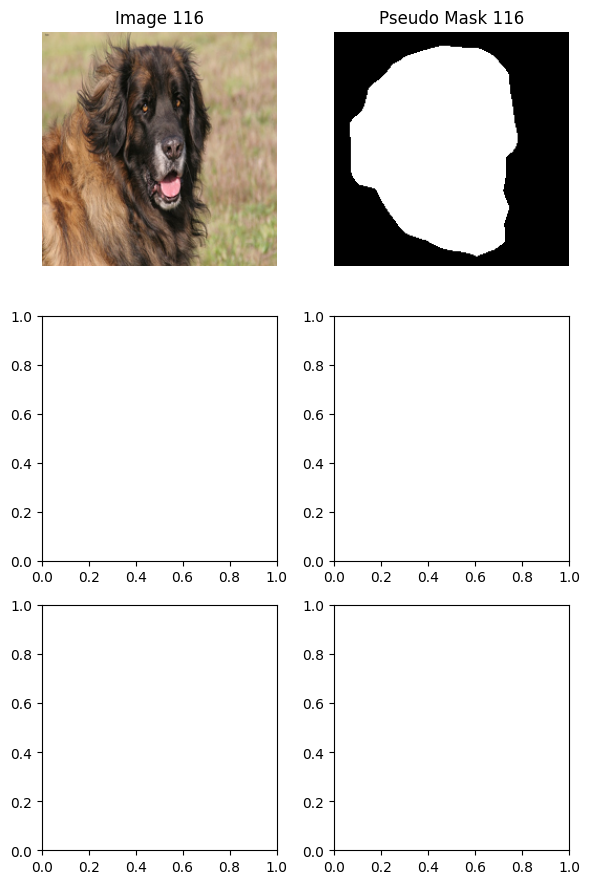

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

[Lambda 0.2] Epoch 1/3, Loss: 3.4990
[Lambda 0.2] Epoch 2/3, Loss: 2.0706
[Lambda 0.2] Epoch 3/3, Loss: 1.4450

 Model Evaluation on Test Set: IoU = 0.4709 | Acc = 0.7669
Iteration 1: Evaluation -> Mean IoU: 0.4709, Mean Acc: 0.7669

### Alternation 2/5
Showing sample pseudo masks after refinement:


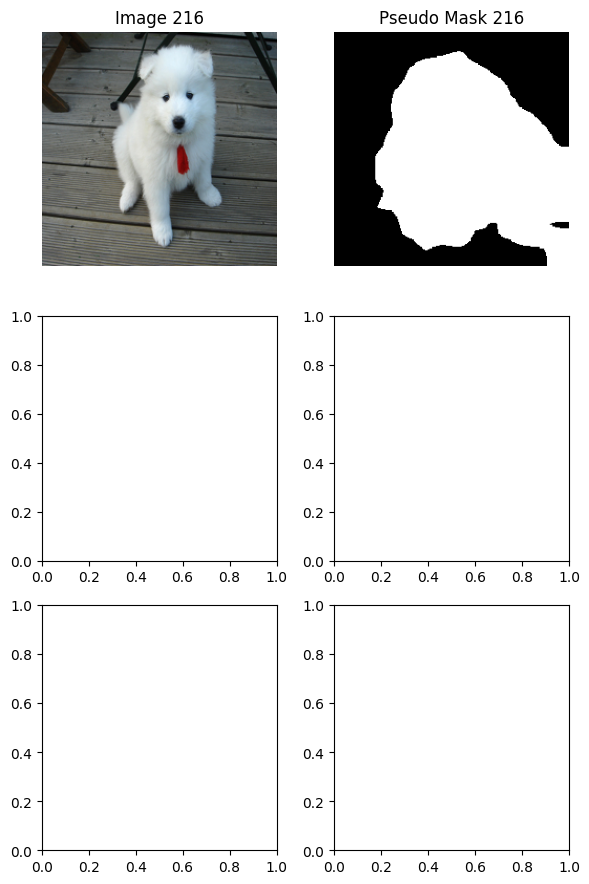

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

[Lambda 0.2] Epoch 1/3, Loss: 4.2635
[Lambda 0.2] Epoch 2/3, Loss: 3.2183
[Lambda 0.2] Epoch 3/3, Loss: 2.4677

 Model Evaluation on Test Set: IoU = 0.4170 | Acc = 0.7037
Iteration 2: Evaluation -> Mean IoU: 0.4170, Mean Acc: 0.7037

### Alternation 3/5
Showing sample pseudo masks after refinement:


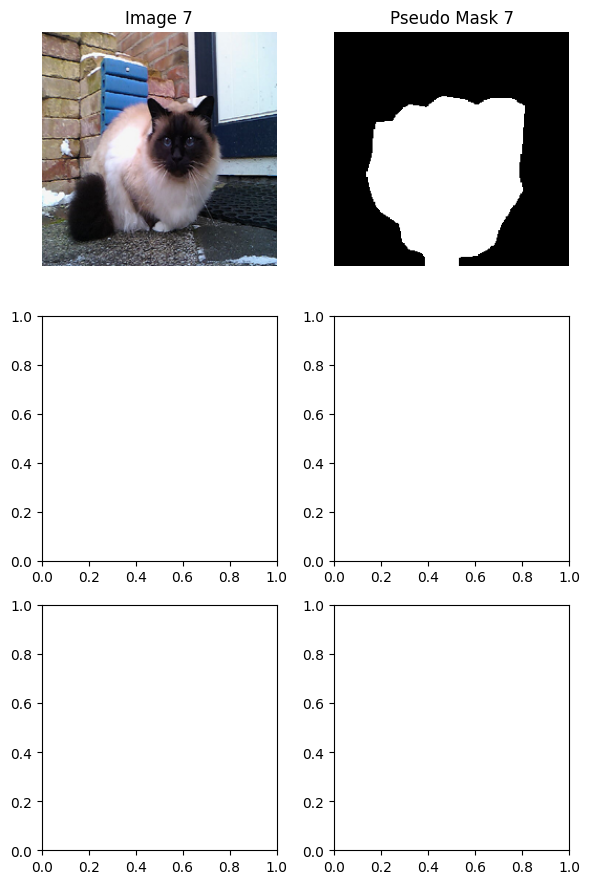

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

[Lambda 0.2] Epoch 1/3, Loss: 4.4495
[Lambda 0.2] Epoch 2/3, Loss: 3.3805
[Lambda 0.2] Epoch 3/3, Loss: 2.6220

 Model Evaluation on Test Set: IoU = 0.4391 | Acc = 0.7006
Iteration 3: Evaluation -> Mean IoU: 0.4391, Mean Acc: 0.7006

### Alternation 4/5
Showing sample pseudo masks after refinement:


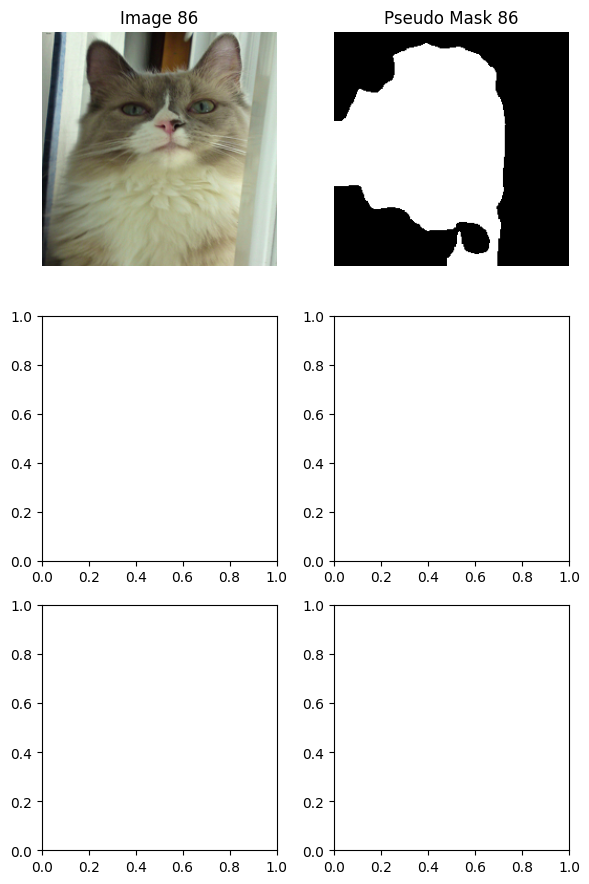

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

[Lambda 0.2] Epoch 1/3, Loss: 4.4421
[Lambda 0.2] Epoch 2/3, Loss: 3.4086
[Lambda 0.2] Epoch 3/3, Loss: 2.5760

 Model Evaluation on Test Set: IoU = 0.4159 | Acc = 0.6813
Iteration 4: Evaluation -> Mean IoU: 0.4159, Mean Acc: 0.6813

### Alternation 5/5
Showing sample pseudo masks after refinement:


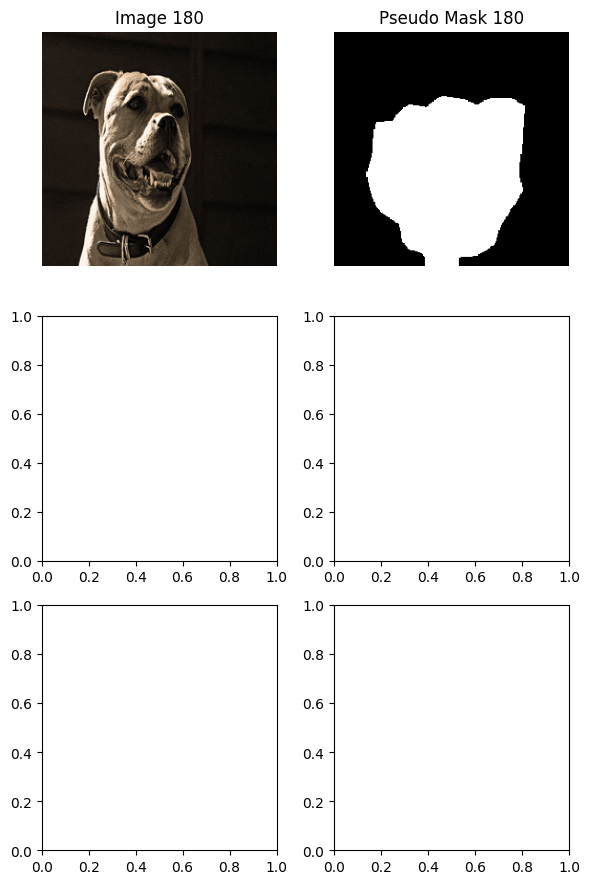

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

[Lambda 0.2] Epoch 1/3, Loss: 4.3595
[Lambda 0.2] Epoch 2/3, Loss: 3.3038
[Lambda 0.2] Epoch 3/3, Loss: 2.5301

 Model Evaluation on Test Set: IoU = 0.4064 | Acc = 0.6977
Iteration 5: Evaluation -> Mean IoU: 0.4064, Mean Acc: 0.6977
Alternating training and pseudo mask updates completed.


In [ ]:
import os
from torchvision.utils import save_image
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision
import torch

# Directories for images and pseudo masks
save_mask_dir = "/content/pseudo_masks"
os.makedirs(save_mask_dir, exist_ok=True)
image_save_dir = "/content/images"
os.makedirs(image_save_dir, exist_ok=True)

# Assume you have a dataset class PseudoSegmentationDataset that reads images and pseudo masks.
# Also assume you have joint_transform already defined.
# And also assume you have your functions: train_model, evaluate_model, and refine_pseudo_mask defined.

# Number of alternating iterations and training epochs per round
num_alternations = 5
epochs_per_round = 3

# Hyperparameters for training/regularization
lambda_boundary = 0.2  # Example value; adjust as needed
momentum = 0.9
sigma_color = 0.1      # Example value for boundary/CRF kernels
sigma_space = 5

# Initialize your dataset and dataloader with initial pseudo masks.
dataset = PseudoSegmentationDataset(
    img_dir="/content/images",
    mask_dir=save_mask_dir,  # Initially contains the first pseudo masks you generated.
    transform=joint_transform
)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize your segmentation model (e.g., DeepLabV3)
def initialize_model():
    num_classes = 2
    model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
    model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
    return model.cuda()

# Optionally, load your existing model if you want to keep refining or initialize freshly
model = initialize_model()

# Main alternating loop
for iteration in range(num_alternations):
    print(f"\n### Alternation {iteration+1}/{num_alternations}")
    import matplotlib.pyplot as plt
    import random

    # --- Visualization: Show a few updated image-mask pairs ---
    print("Showing sample pseudo masks after refinement:")
    sample_indices = random.sample(range(len(dataset)), k=1)

    fig, axs = plt.subplots(len(sample_indices), 2, figsize=(6, 3 * len(sample_indices)))

    for i, idx in enumerate(sample_indices):
      img_path = os.path.join("/content/images", f"{idx}.png")
      mask_path = os.path.join(save_mask_dir, f"{idx}.png")

      img_tensor = torchvision.io.read_image(img_path).float() / 255.0  # Normalize image to [0, 1]
      mask_tensor = torchvision.io.read_image(mask_path)[0]  # Get single channel (mask)

      # Plot image
      axs[i, 0].imshow(img_tensor.permute(1, 2, 0))  # Convert from CxHxW to HxWxC for plotting
      axs[i, 0].set_title(f"Image {idx}")
      axs[i, 0].axis('off')  # Hide axes

      # Plot mask
      axs[i, 1].imshow(mask_tensor, cmap="gray")  # Grayscale for masks
      axs[i, 1].set_title(f"Pseudo Mask {idx}")
      axs[i, 1].axis('off')  # Hide axes
      plt.tight_layout()
      plt.show()

    # --- Step 1: Train the model on current pseudo masks ---
    model = train_model(
        lambda_boundary=lambda_boundary,
        num_epochs=epochs_per_round,
        momentum=momentum,
        sigma_color=sigma_color,
        sigma_space=sigma_space
    )
    # Optionally, evaluate on a validation set to monitor improvement
    avg_iou, avg_acc = evaluate_model(model, test_loader)
    print(f"Iteration {iteration+1}: Evaluation -> Mean IoU: {avg_iou:.4f}, Mean Acc: {avg_acc:.4f}")

    # --- Step 2: Update (Refine) the pseudo masks ---
    # Loop through each image in the training set, refine the pseudo mask, and save the updated mask.
    new_mask_paths = []
    for idx, (img, mask) in enumerate(dataset):
        # img has shape (C, H, W); ensure it is on the proper device
        refined_mask = refine_pseudo_mask(model, img, mask, threshold=0.5, num_steps = 2, lambda_boundary=lambda_boundary)
        # Save the refined pseudo mask (overwrite the previous one)
        mask_path = os.path.join(save_mask_dir, f"{idx}.png")
        save_image(refined_mask.unsqueeze(0).float(), mask_path)
        new_mask_paths.append(mask_path)

    # Option 2: If your dataset caches the masks, you might need to reinitialize your dataset.
    dataset = PseudoSegmentationDataset(
        img_dir="/content/images",
        mask_dir=save_mask_dir,  # now updated with refined masks
        transform=joint_transform
    )
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


print("Alternating training and pseudo mask updates completed.")


### Random Search through hyperparameter space

In [ ]:
generate_pseudo_masks(loader, layercam_gen, cam_thresh=0.5, alpha=2.0, crf_compat = 10, keep_largest_masks = True, apply_crf = False)

In [ ]:
import os
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import torchvision
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision.utils import save_image
import numpy as np

# Directories for images and pseudo masks
save_mask_dir = "/content/pseudo_masks"
os.makedirs(save_mask_dir, exist_ok=True)
image_save_dir = "/content/images"
os.makedirs(image_save_dir, exist_ok=True)

# Hyperparameter search space
sigma_color_candidates = [0.01, 0.1, 0.2, 0.5]
sigma_space_candidates = [5, 10, 20, 40]
lambda_candidates = [0.05, 0.1, 0.2, 0.5]

# Number of trials for random search
num_trials = 15
repeats = 3  # Number of repeats per trial
outer_repeats = 3  # Outer repeat loop for error estimation

# Results storage
results = defaultdict(list)


# Initialize your segmentation model (e.g., DeepLabV3)
def initialize_model():
    num_classes = 2
    model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
    model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
    return model.cuda()

# Optionally, load your existing model if you want to keep refining or initialize freshly
model = initialize_model()


# Random search loop for trials
for trial in range(num_trials):
  # Randomly sample hyperparameters for this trial
  sigma_color = random.choice(sigma_color_candidates)
  sigma_space = random.choice(sigma_space_candidates)
  lambda_boundary = random.choice(lambda_candidates)
  key = (sigma_color, sigma_space, lambda_boundary)

  print(f"  Trial {trial+1}/{num_trials}: sigma_color={sigma_color}, sigma_space={sigma_space}, lambda={lambda_boundary}")

  # Track results for this combination
  trial_results = []
  # Outer loop for error estimation
  for outer_trial in range(outer_repeats):
    print(f"\nOuter Trial {outer_trial+1}/{outer_repeats}")

    # Reset pseudomasks
    generate_pseudo_masks(loader, layercam_gen, cam_thresh=0.5, alpha=2.0, crf_compat = 10, keep_largest_masks = True, apply_crf = False)
    # Initialize your dataset and dataloader with initial pseudo masks.
    dataset = PseudoSegmentationDataset(
      img_dir="/content/images",
      mask_dir=save_mask_dir,  # Initially contains the first pseudo masks you generated.
      transform=joint_transform
    )
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


    # Perform repeats for each trial (inner loop)
    for rep in range(repeats):
      print(f"    Repeat {rep+1}/{repeats}...")

      # --- Step 1: Train the model on current pseudo masks ---
      model = train_model(
            lambda_boundary=lambda_boundary,
            num_epochs=15,  # Define how many epochs per round
            momentum=0.9,
            sigma_color=sigma_color,
            sigma_space=sigma_space
            )

      # Optionally, evaluate on a validation set to monitor improvement
      #avg_iou, avg_acc = evaluate_model(model, test_loader)
      #print(f"    Evaluation -> Mean IoU: {avg_iou:.4f}, Mean Acc: {avg_acc:.4f}")

      # --- Step 2: Update (Refine) the pseudo masks ---
      # Loop through each image in the training set, refine the pseudo mask, and save the updated mask.
      new_mask_paths = []
      for idx, (img, mask) in enumerate(dataset):
          # img has shape (C, H, W); ensure it is on the proper device
          refined_mask = refine_pseudo_mask(model, img, mask, threshold=0.5, num_steps=100, lambda_boundary=lambda_boundary)
          # Save the refined pseudo mask (overwrite the previous one)
          mask_path = os.path.join(save_mask_dir, f"{idx}.png")
          save_image(refined_mask.unsqueeze(0).float(), mask_path)
          new_mask_paths.append(mask_path)

      # Option 2: If your dataset caches the masks, you might need to reinitialize your dataset.
      dataset = PseudoSegmentationDataset(
                img_dir="/content/images",
                mask_dir=save_mask_dir,  # now updated with refined masks
                transform=joint_transform
            )
      train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

    avg_iou, avg_acc = evaluate_model(model, test_loader)
    print(f"End of Repeat: {outer_trial} for params: sigma_color={sigma_color}, sigma_space={sigma_space}, lambda={lambda_boundary}")
    print(f"    Evaluation -> IoU: {avg_iou:.4f}, Acc: {avg_acc:.4f}")
    trial_results.append((avg_iou, avg_acc))

  # After all repeats for this trial, calculate the mean and std error
  trial_iou = [iou for iou, _ in trial_results]
  trial_acc = [acc for _, acc in trial_results]

  mean_iou = np.mean(trial_iou)
  std_iou = np.std(trial_iou)
  mean_acc = np.mean(trial_acc)
  std_acc = np.std(trial_acc)

  print(f"  Trial {trial+1} Results -> Mean IoU: {mean_iou:.4f}, Std IoU: {std_iou:.4f}, Mean Acc: {mean_acc:.4f}, Std Acc: {std_acc:.4f}")

  # Store the trial results with error estimate
  results[key].append((mean_iou, std_iou, mean_acc, std_acc))

# Print the final results from all outer trials
print("\nRandom search completed. Final results:")

# Output results with error estimates (mean ± std)
for key, trial_results in results.items():
    print(f"\nConfiguration: sigma_color={key[0]}, sigma_space={key[1]}, lambda_boundary={key[2]}")
    for i, (mean_iou, std_iou, mean_acc, std_acc) in enumerate(trial_results):
        print(f"  Outer Trial {i+1} -> Mean IoU: {mean_iou:.4f} ± {std_iou:.4f}, Mean Acc: {mean_acc:.4f} ± {std_acc:.4f}")


  Trial 1/15: sigma_color=0.1, sigma_space=40, lambda=0.1

Outer Trial 1/3
Pseudo masks saved to: /content/pseudo_masks
Images saved to: /content/images
    Repeat 1/3...
[Lambda 0.1] Epoch 1/15, Loss: 3.6394
[Lambda 0.1] Epoch 2/15, Loss: 2.1552
[Lambda 0.1] Epoch 3/15, Loss: 1.4358
[Lambda 0.1] Epoch 4/15, Loss: 1.1365
[Lambda 0.1] Epoch 5/15, Loss: 0.9908
[Lambda 0.1] Epoch 6/15, Loss: 0.9179
[Lambda 0.1] Epoch 7/15, Loss: 0.8337
[Lambda 0.1] Epoch 8/15, Loss: 0.7519
[Lambda 0.1] Epoch 9/15, Loss: 0.6818
[Lambda 0.1] Epoch 10/15, Loss: 0.6433
[Lambda 0.1] Epoch 11/15, Loss: 0.5851
[Lambda 0.1] Epoch 12/15, Loss: 0.5817


In [ ]:
import re
from collections import defaultdict
import matplotlib.pyplot as plt

# Example log snippet
log_text = """"""  # Replace this with your full log string or read from a file

# Regular expression pattern to extract trial results
trial_pattern = re.compile(
    r"Trial\s+(?P<trial_num>\d+)/\d+: sigma_color=(?P<sigma_color>[\d.]+), sigma_space=(?P<sigma_space>[\d.]+), lambda=(?P<lambda>[\d.]+).*?"
    r"Trial\s+\d+ Results -> Mean IoU: (?P<mean_iou>[\d.]+), Std IoU: (?P<std_iou>[\d.]+), Mean Acc: (?P<mean_acc>[\d.]+), Std Acc: (?P<std_acc>[\d.]+)",
    re.DOTALL
)

# Extracted results dictionary
results = []

for match in trial_pattern.finditer(log_text):
    trial = {
        "trial": int(match.group("trial_num")),
        "sigma_color": float(match.group("sigma_color")),
        "sigma_space": float(match.group("sigma_space")),
        "lambda": float(match.group("lambda")),
        "mean_iou": float(match.group("mean_iou")),
        "std_iou": float(match.group("std_iou")),
        "mean_acc": float(match.group("mean_acc")),
        "std_acc": float(match.group("std_acc"))
    }
    results.append(trial)

print(results)
# Organize results by lambda for plotting
def plot_metric(results, metric="mean_iou"):
    lambdas = sorted(set(r["lambda"] for r in results))
    for lam in lambdas:
        filtered = [r for r in results if r["lambda"] == lam]
        x = [r["sigma_color"] for r in filtered]
        y = [r[metric] for r in filtered]
        plt.plot(x, y, marker='o', label=f"lambda={lam}")
    plt.xlabel("Sigma Color")
    plt.ylabel(metric.replace("_", " ").title())
    plt.title(f"{metric.replace('_', ' ').title()} vs Sigma Color")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot IoU and Accuracy
plot_metric(results, "mean_iou")
plot_metric(results, "mean_acc")

import matplotlib.pyplot as plt
import itertools

# Get unique keys
keys = list(results[0].keys())

# Separate features and metrics
features = ['sigma_color', 'sigma_space', 'lambda']
metrics = ['mean_iou', 'mean_acc']

# Organize data by column
columns = {k: [d[k] for d in results] for k in keys}

num_features = len(features)
fig, axes = plt.subplots(num_features, num_features, figsize=(12, 12))

for i, feat_x in enumerate(features):
    for j, feat_y in enumerate(features):
        ax = axes[i, j]
        if i == j:
            # Diagonal: just show hist
            ax.hist(columns[feat_x], bins=10, color='skyblue')
            ax.set_ylabel(feat_x)
        else:
            # Off-diagonal: scatter plot
            sc = ax.scatter(columns[feat_y], columns[feat_x], c=columns['mean_iou'], cmap='viridis')
            if j == 0:
                ax.set_ylabel(feat_x)
            if i == num_features - 1:
                ax.set_xlabel(feat_y)

plt.tight_layout()
fig.colorbar(sc, ax=axes, orientation='vertical', fraction=0.02, pad=0.02, label='Mean IoU')
plt.show()

# Optional: Access raw results
print("Results Summary:")
for r in results:
    print(r)

Pseudo masks saved to: /content/pseudo_masks
Images saved to: /content/images


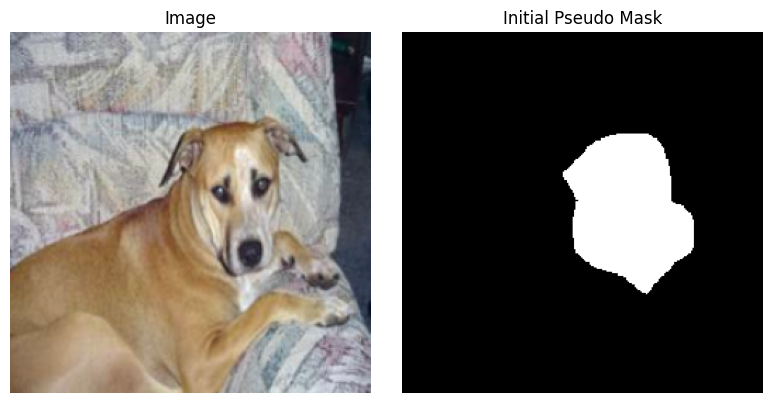

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



### Alternation 1/5
[Lambda 0.5] Epoch 1/15, Loss: 4.5443
[Lambda 0.5] Epoch 2/15, Loss: 3.2967
[Lambda 0.5] Epoch 3/15, Loss: 2.2970
[Lambda 0.5] Epoch 4/15, Loss: 1.7003
[Lambda 0.5] Epoch 5/15, Loss: 1.4021
[Lambda 0.5] Epoch 6/15, Loss: 1.2447
[Lambda 0.5] Epoch 7/15, Loss: 1.1265
[Lambda 0.5] Epoch 8/15, Loss: 1.0347
[Lambda 0.5] Epoch 9/15, Loss: 0.9576
[Lambda 0.5] Epoch 10/15, Loss: 0.8987
[Lambda 0.5] Epoch 11/15, Loss: 0.8504
[Lambda 0.5] Epoch 12/15, Loss: 0.8121
[Lambda 0.5] Epoch 13/15, Loss: 0.7685
[Lambda 0.5] Epoch 14/15, Loss: 0.7338
[Lambda 0.5] Epoch 15/15, Loss: 0.6923


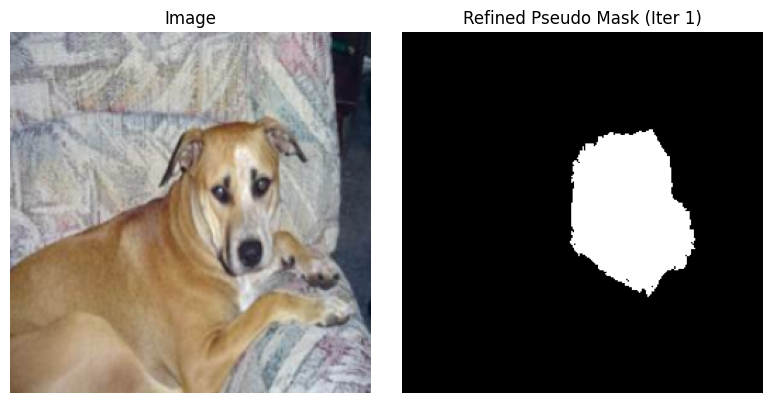


### Alternation 2/5
[Lambda 0.5] Epoch 1/15, Loss: 3.8810
[Lambda 0.5] Epoch 2/15, Loss: 3.2672
[Lambda 0.5] Epoch 3/15, Loss: 2.7223
[Lambda 0.5] Epoch 4/15, Loss: 2.1784
[Lambda 0.5] Epoch 5/15, Loss: 1.7443
[Lambda 0.5] Epoch 6/15, Loss: 1.4440
[Lambda 0.5] Epoch 7/15, Loss: 1.2799
[Lambda 0.5] Epoch 8/15, Loss: 1.1490
[Lambda 0.5] Epoch 9/15, Loss: 1.0541
[Lambda 0.5] Epoch 10/15, Loss: 0.9536
[Lambda 0.5] Epoch 11/15, Loss: 0.8777
[Lambda 0.5] Epoch 12/15, Loss: 0.8190
[Lambda 0.5] Epoch 13/15, Loss: 0.7634
[Lambda 0.5] Epoch 14/15, Loss: 0.7230
[Lambda 0.5] Epoch 15/15, Loss: 0.6836


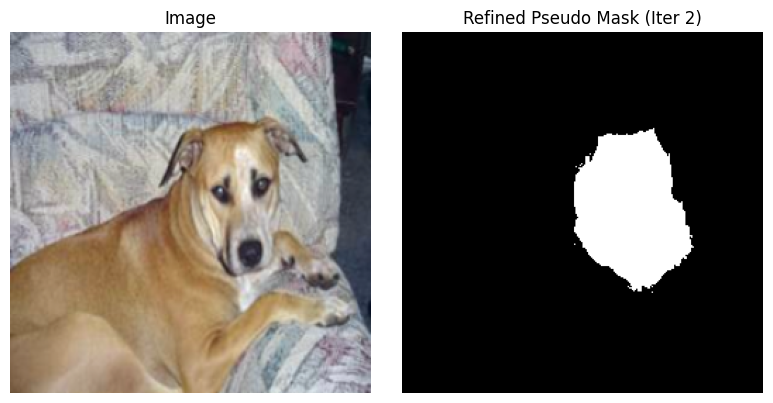


### Alternation 3/5
[Lambda 0.5] Epoch 1/15, Loss: 5.1313
[Lambda 0.5] Epoch 2/15, Loss: 4.2389
[Lambda 0.5] Epoch 3/15, Loss: 3.4439
[Lambda 0.5] Epoch 4/15, Loss: 2.6094
[Lambda 0.5] Epoch 5/15, Loss: 2.0275
[Lambda 0.5] Epoch 6/15, Loss: 1.7222
[Lambda 0.5] Epoch 7/15, Loss: 1.5081
[Lambda 0.5] Epoch 8/15, Loss: 1.3276
[Lambda 0.5] Epoch 9/15, Loss: 1.2001
[Lambda 0.5] Epoch 10/15, Loss: 1.1155
[Lambda 0.5] Epoch 11/15, Loss: 1.0343
[Lambda 0.5] Epoch 12/15, Loss: 0.9711
[Lambda 0.5] Epoch 13/15, Loss: 0.9079
[Lambda 0.5] Epoch 14/15, Loss: 0.8575
[Lambda 0.5] Epoch 15/15, Loss: 0.8089


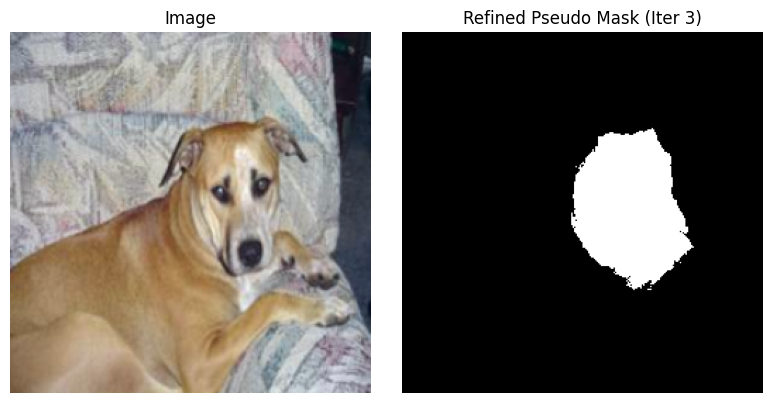


### Alternation 4/5
[Lambda 0.5] Epoch 1/15, Loss: 4.2794
[Lambda 0.5] Epoch 2/15, Loss: 3.5966
[Lambda 0.5] Epoch 3/15, Loss: 2.9565
[Lambda 0.5] Epoch 4/15, Loss: 2.3381
[Lambda 0.5] Epoch 5/15, Loss: 1.8602
[Lambda 0.5] Epoch 6/15, Loss: 1.5572
[Lambda 0.5] Epoch 7/15, Loss: 1.3434
[Lambda 0.5] Epoch 8/15, Loss: 1.1965
[Lambda 0.5] Epoch 9/15, Loss: 1.1068
[Lambda 0.5] Epoch 10/15, Loss: 1.0184
[Lambda 0.5] Epoch 11/15, Loss: 0.9294
[Lambda 0.5] Epoch 12/15, Loss: 0.8684
[Lambda 0.5] Epoch 13/15, Loss: 0.8228
[Lambda 0.5] Epoch 14/15, Loss: 0.7735
[Lambda 0.5] Epoch 15/15, Loss: 0.7373


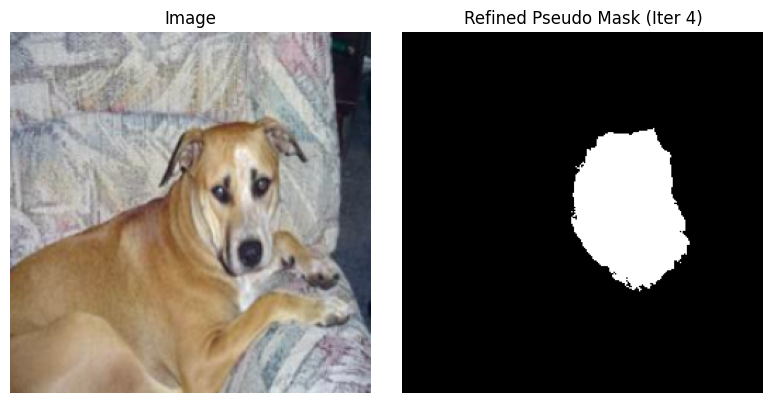

KeyboardInterrupt: 

In [ ]:
import os
from torchvision.utils import save_image
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision
import torch
import matplotlib.pyplot as plt
import random

generate_pseudo_masks(loader, layercam_gen, cam_thresh=0.5, alpha=1.0, crf_compat = 10, keep_largest_masks = True, apply_crf = False)

# Directories for images and pseudo masks
save_mask_dir = "/content/pseudo_masks"
os.makedirs(save_mask_dir, exist_ok=True)
image_save_dir = "/content/images"
os.makedirs(image_save_dir, exist_ok=True)

# Number of alternating iterations and training epochs per round
num_alternations = 5
epochs_per_round = 15
visualize_idx = 0

# Hyperparameters for training/regularization
lambda_boundary = 0.5
momentum = 0.9
sigma_color = 0.1
sigma_space = 10

# Initialize your dataset and dataloader with initial pseudo masks.
dataset = PseudoSegmentationDataset(
    img_dir="/content/images",
    mask_dir=save_mask_dir,  # Initially contains the first pseudo masks you generated.
    transform=joint_transform
)

# Plot out initial mask
initial_img, initial_mask = dataset[visualize_idx]
# Convert to numpy for plotting
img_np = initial_img.cpu().numpy().transpose(1, 2, 0)
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # Normalize to [0,1]
mask_np = initial_mask.cpu().numpy()

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title("Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask_np, cmap='gray')
plt.title("Initial Pseudo Mask")
plt.axis("off")

plt.tight_layout()
plt.show()

train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize segmentation model
def initialize_model():
    num_classes = 2
    model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
    model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
    return model.cuda()

# Optionally, load your existing model if you want to keep refining or initialize freshly
model = initialize_model()

# Main alternating loop
for iteration in range(num_alternations):
    print(f"\n### Alternation {iteration+1}/{num_alternations}")

    # --- Step 1: Train the model on current pseudo masks ---
    model.train()
    model = train_model(
        lambda_boundary=lambda_boundary,
        num_epochs=epochs_per_round,
        momentum=momentum,
        sigma_color=sigma_color,
        sigma_space=sigma_space
    )
    # Evaluate on a validation set to monitor improvement
    #avg_iou, avg_acc = evaluate_model(model, test_loader)
    #print(f"Iteration {iteration+1}: Evaluation -> Mean IoU: {avg_iou:.4f}, Mean Acc: {avg_acc:.4f}")

    # --- Step 2: Update the pseudo masks ---
    # Loop through each image in the training set, refine the pseudo mask, and save the updated mask.
    new_mask_paths = []
    for idx, (img, mask) in enumerate(dataset):
        # img has shape (C, H, W); ensure it is on the proper device
        refined_mask = refine_pseudo_mask(model, img, mask, threshold=0.5, num_steps = 75, lambda_boundary=lambda_boundary)
        # Save the refined pseudo mask (overwrite the previous one)
        mask_path = os.path.join(save_mask_dir, f"{idx}.png")
        save_image(refined_mask.unsqueeze(0).float(), mask_path)
        new_mask_paths.append(mask_path)

        if idx == visualize_idx:
            # Ensure image is in range [0, 1] for plotting
            img_np = img.cpu().numpy().transpose(1, 2, 0)
            img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

            mask_np = refined_mask.cpu().numpy()

            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(img_np)
            plt.title("Image")
            plt.axis("off")

            plt.subplot(1, 2, 2)
            plt.imshow(mask_np, cmap='gray')
            plt.title(f"Refined Pseudo Mask (Iter {iteration+1})")
            plt.axis("off")

            plt.tight_layout()
            plt.show()

    # Option 2: If your dataset caches the masks, you might need to reinitialize your dataset.
    dataset = PseudoSegmentationDataset(
        img_dir="/content/images",
        mask_dir=save_mask_dir,  # now updated with refined masks
        transform=joint_transform
    )
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


print("Alternating training and pseudo mask updates completed.")

Segmentation Model: IoU: 0.020 | Accuracy: 0.015


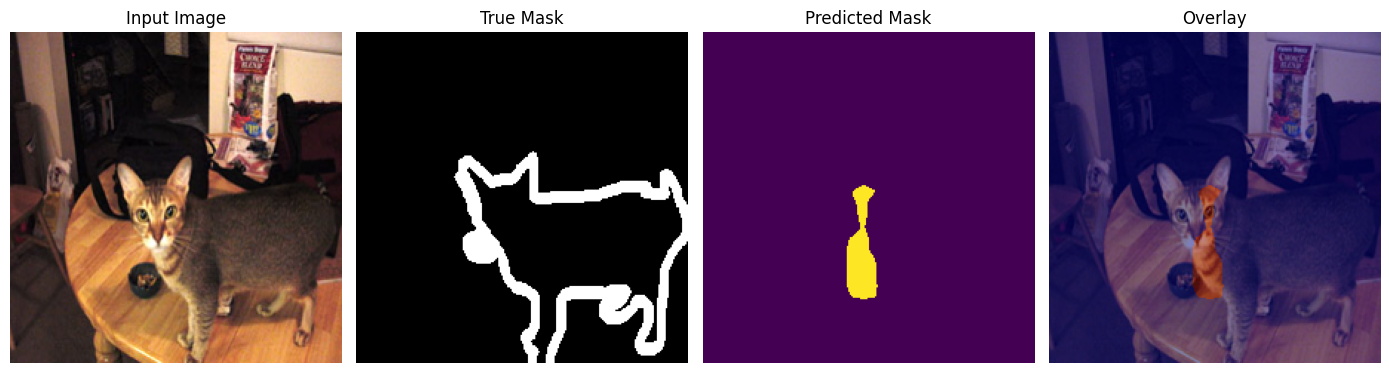

In [ ]:
model.eval()


for img, (label, true_mask) in test_loader:
    img = img[0].to(device)  # (3, H, W)
    true_mask = true_mask[0].to(device)

    # Normalize ground truth to binary (0 = background, 1 = foreground)
    true_mask = true_mask.clone()
    true_mask[true_mask == 2] = 1
    true_mask[true_mask == 0] = 0

    # Get model prediction
    with torch.no_grad():
        input_tensor = img.unsqueeze(0)  # (1, 3, H, W)
        output = model(input_tensor)['out']  # (1, C, H, W)
        pred = torch.argmax(output.squeeze(), dim=0)  # (H, W)

    # Resize prediction if needed
    if pred.shape != true_mask.shape:
        pred = F.interpolate(pred.unsqueeze(0).unsqueeze(0).float(),
                             size=true_mask.shape[-2:], mode='nearest').squeeze().long()

    # Compute IoU and accuracy
    iou_seg, acc_seg = compute_iou_and_acc(pred, true_mask)

    print(f"Segmentation Model: IoU: {iou_seg:.3f} | Accuracy: {acc_seg:.3f}")

    # --- Visualization ---
    fig, ax = plt.subplots(1, 4, figsize=(14, 4))

    ax[0].imshow(img.cpu().permute(1, 2, 0).numpy())
    ax[0].set_title("Input Image")
    ax[0].axis('off')

    ax[1].imshow(true_mask.squeeze(0).cpu().numpy(), cmap='gray')
    ax[1].set_title("True Mask")
    ax[1].axis('off')

    ax[2].imshow(pred.cpu().numpy())
    ax[2].set_title("Predicted Mask")
    ax[2].axis('off')

    # Optional: Overlay
    overlay = overlay_cam_on_image(img, pred.float(), alpha=0.5, colormap='jet')
    ax[3].imshow(overlay)
    ax[3].set_title("Overlay")
    ax[3].axis('off')

    plt.tight_layout()
    plt.show()

    if p == 5:
        break
    p += 1